<a href="https://colab.research.google.com/github/Gingerhouse/MLSurvivalAnalysis/blob/main/cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/gunesevitan/breast-cancer-metabric

In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 24.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Abel_MS_project/report'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1l3jgNdRsAUspJoxZ4aWodURA6lvniwC3/Abel_MS_project/report


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, ShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
# from sklearn.impute import IterativeImputer

from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import as_concordance_index_ipcw_scorer, as_cumulative_dynamic_auc_scorer, as_integrated_brier_score_scorer, cumulative_dynamic_auc, integrated_brier_score, concordance_index_ipcw
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.column import standardize
from sksurv.compare import compare_survival
from sksurv.svm import FastSurvivalSVM

# Preprocessing

In [ ]:
df = pd.read_csv('Breast Cancer METABRIC.csv')
df

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,MTS-T2428,70.05,NaN,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,NaN,1.0,Positve,...,NaN,NaN,NaN,4.93,Recurred,Female,NaN,27.0,1.0,NaN
2505,MTS-T2429,63.60,NaN,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,NaN,1.0,Positve,...,NaN,NaN,NaN,16.18,Recurred,Female,NaN,28.0,2.0,NaN
2506,MTS-T2430,NaN,NaN,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,NaN,NaN,0.0,NaN
2507,MTS-T2431,NaN,NaN,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,NaN,NaN,0.0,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Diagnosis,2498.0,60.420300,13.032997,21.93,50.920000,61.110000,70.000000,96.29
Cohort,2498.0,2.900320,1.962216,1.00,1.000000,3.000000,4.000000,9.00
Neoplasm Histologic Grade,2388.0,2.412060,0.649363,1.00,2.000000,3.000000,3.000000,3.00
Lymph nodes examined positive,2243.0,1.950513,4.017774,0.00,0.000000,0.000000,2.000000,45.00
Mutation Count,2357.0,5.578702,3.967967,1.00,3.000000,5.000000,7.000000,80.00
Nottingham prognostic index,2287.0,4.028787,1.189092,1.00,3.048000,4.044000,5.040000,7.20
Overall Survival (Months),1981.0,125.244271,76.111772,0.00,60.866667,116.466667,185.133333,355.20
Relapse Free Status (Months),2388.0,108.842487,76.519494,0.00,40.560000,99.095000,167.640000,384.21
Tumor Size,2360.0,26.220093,15.370883,1.00,17.000000,22.410000,30.000000,182.00
Tumor Stage,1788.0,1.713647,0.655307,0.00,1.000000,2.000000,2.000000,4.00


<ipython-input-7-452bdfd0f231>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age at Diagnosis'])


<Axes: xlabel='Age at Diagnosis', ylabel='Density'>

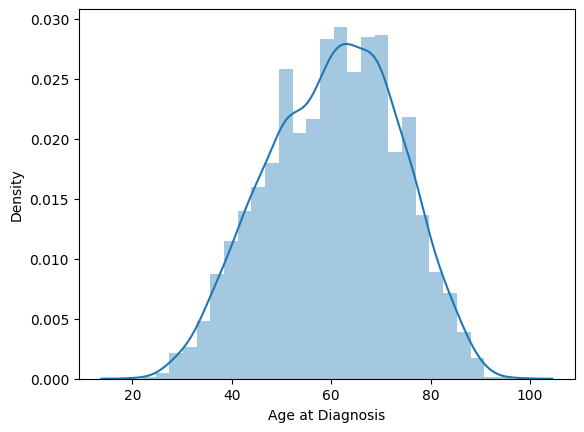

In [ ]:
sns.distplot(df['Age at Diagnosis'])

<Axes: xlabel='count', ylabel='Type of Breast Surgery'>

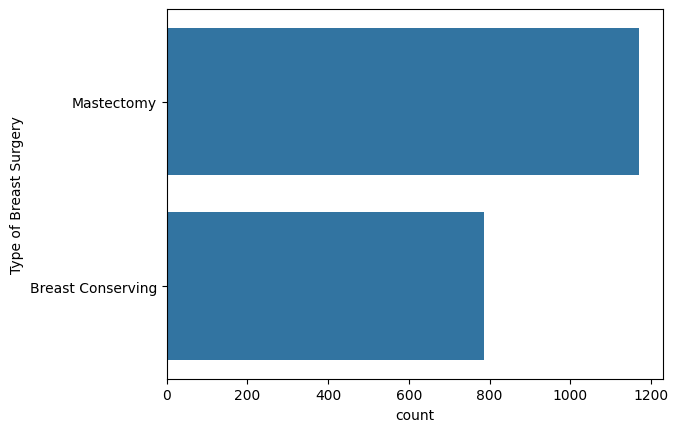

In [ ]:
sns.countplot(df['Type of Breast Surgery'])

<Axes: xlabel='count', ylabel='Cancer Type'>

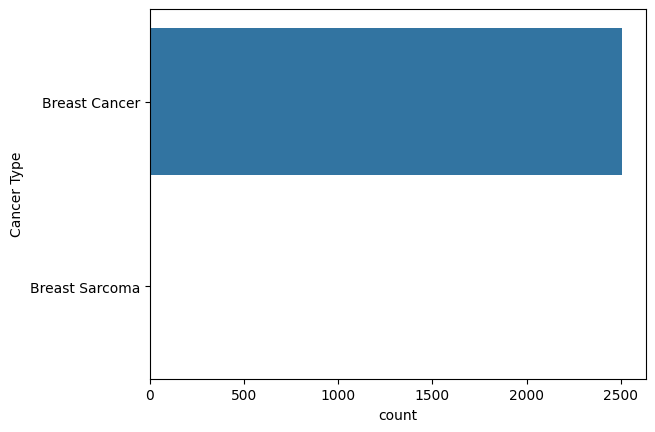

In [ ]:
sns.countplot(df['Cancer Type'])

<Axes: xlabel='count', ylabel='Cancer Type Detailed'>

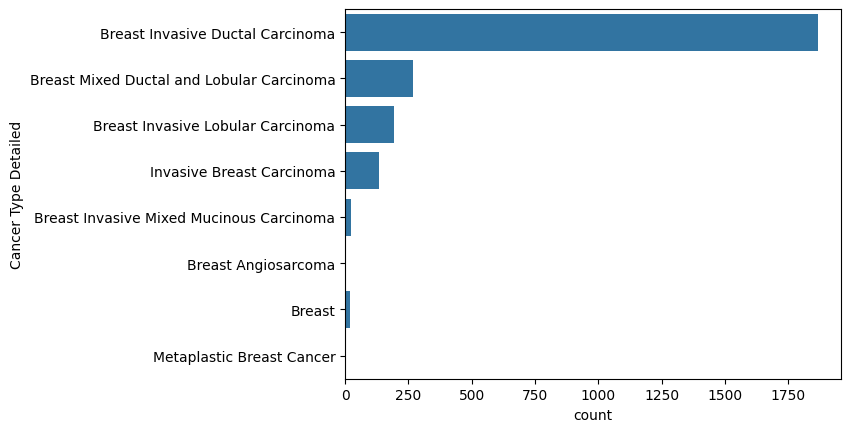

In [ ]:
sns.countplot(df['Cancer Type Detailed'])

<ipython-input-11-097a95a82e32>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,


Text(0, 0.5, '')

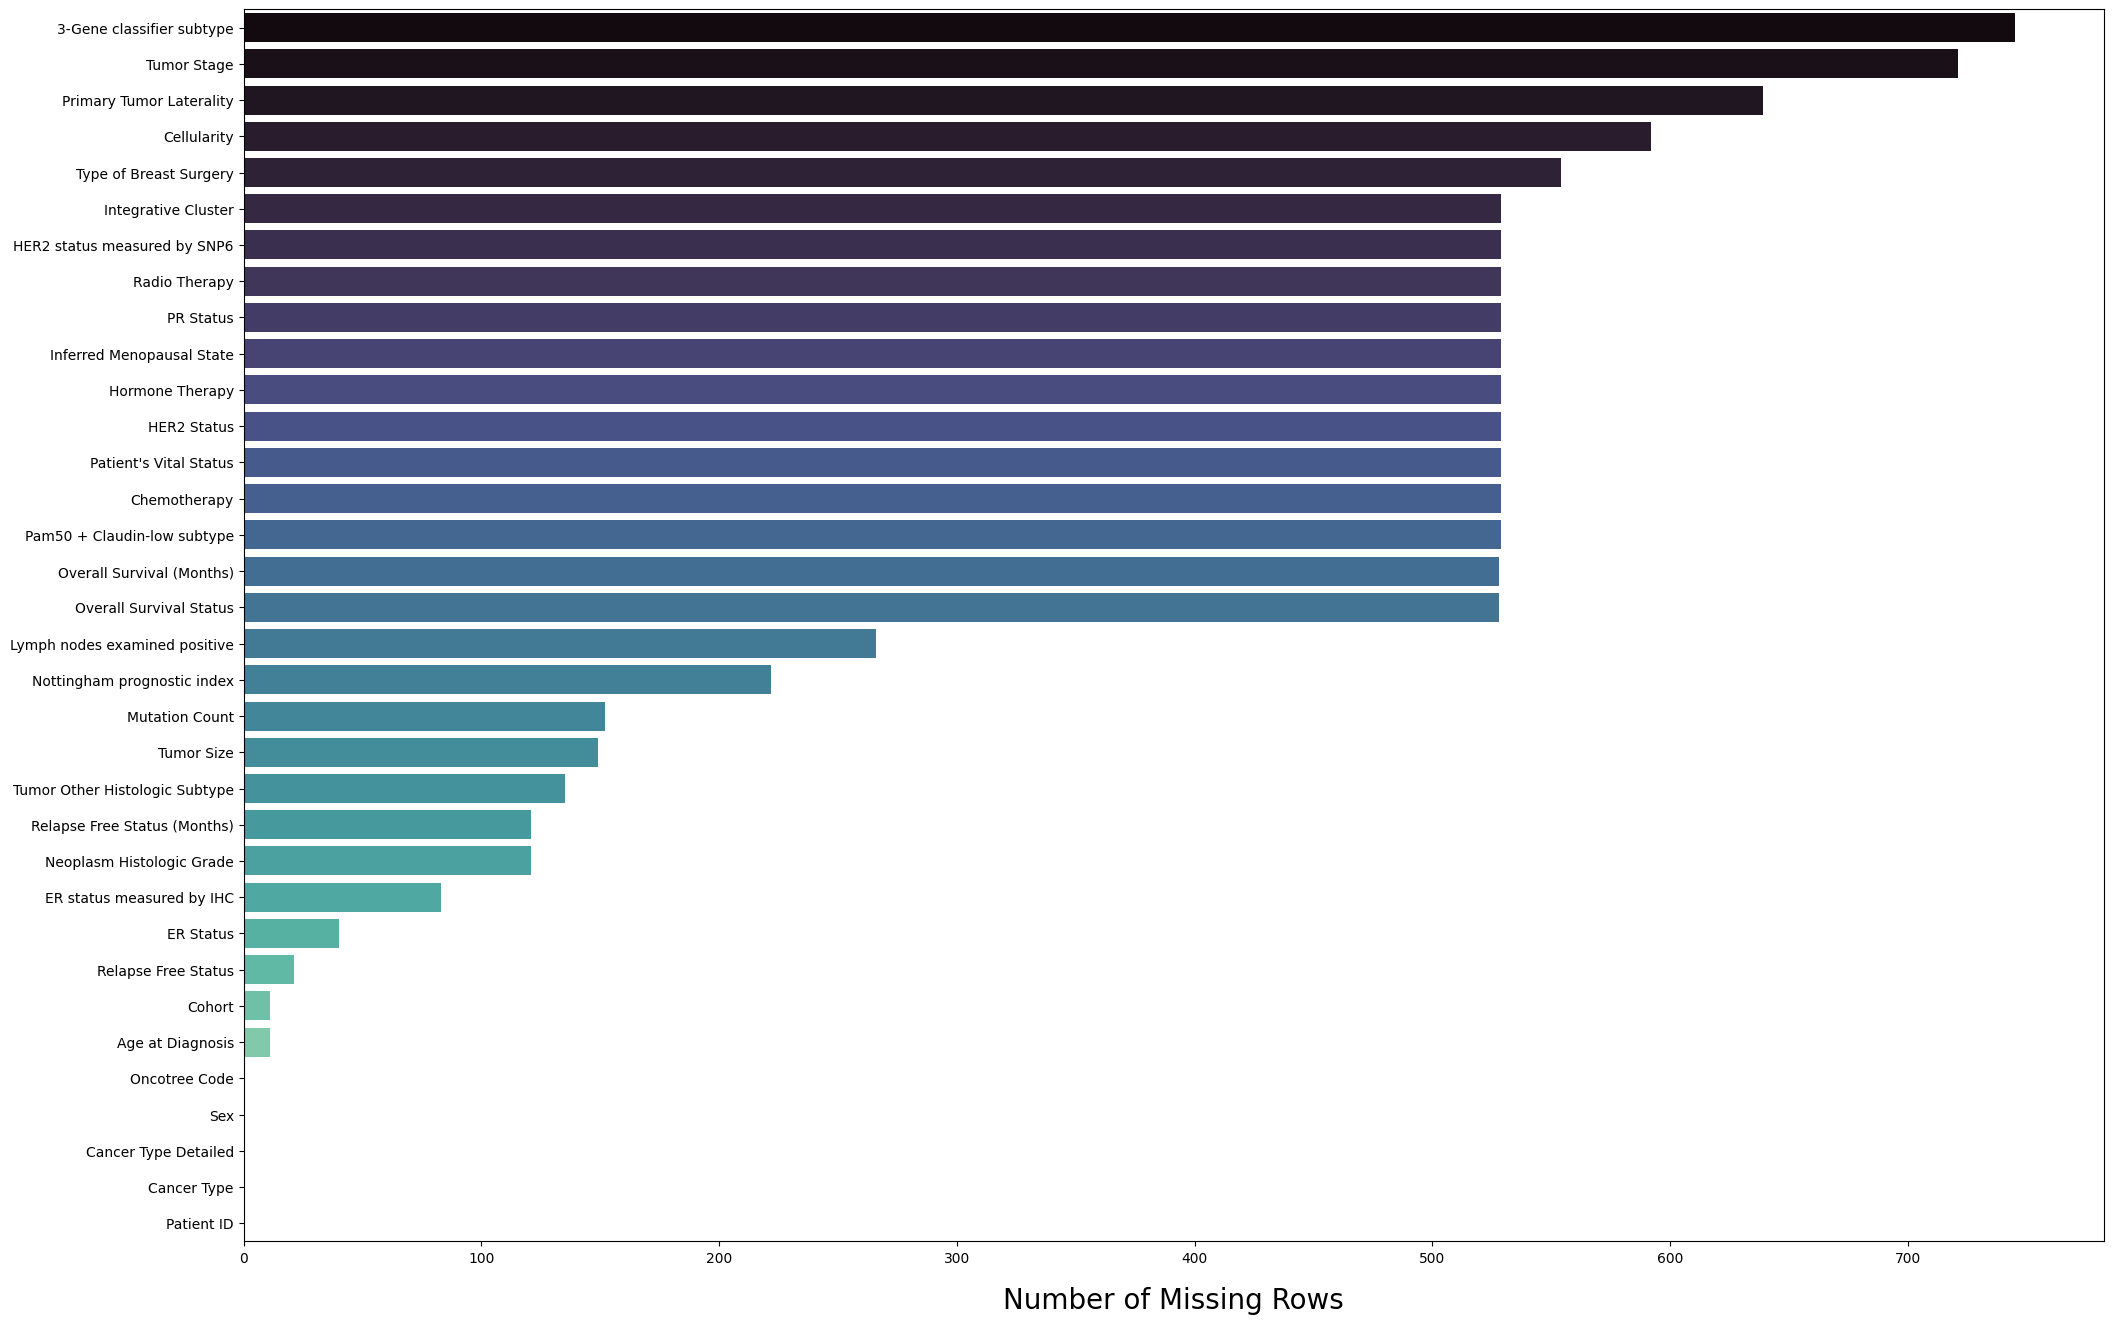

In [ ]:
fig = plt.figure(figsize=(24, 16))
sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,
            y=df.isnull().sum().sort_values(ascending=False).index,
            palette='mako')
plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')

<ipython-input-12-eaedbf760f74>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Overall Survival (Months)'])


<Axes: xlabel='Overall Survival (Months)', ylabel='Density'>

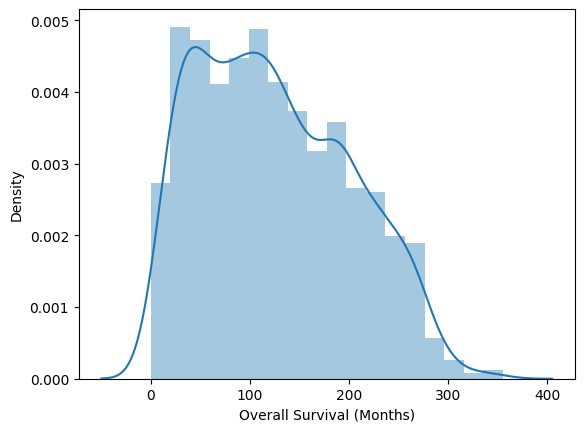

In [ ]:
sns.distplot(df['Overall Survival (Months)'])

<Axes: xlabel='count', ylabel='Overall Survival Status'>

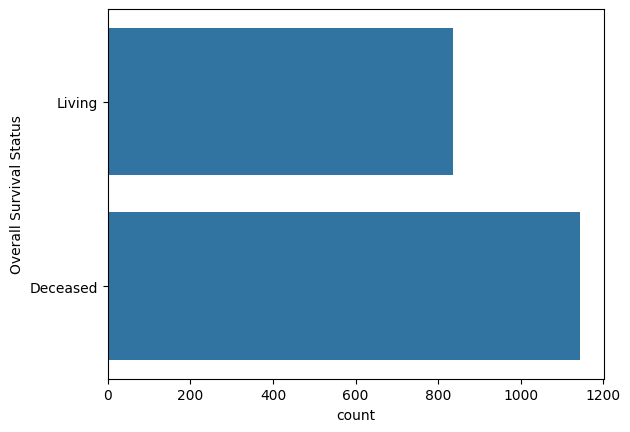

In [ ]:
sns.countplot(df['Overall Survival Status'])

<ipython-input-14-814c0ec51c09>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Relapse Free Status (Months)'])


<Axes: xlabel='Relapse Free Status (Months)', ylabel='Density'>

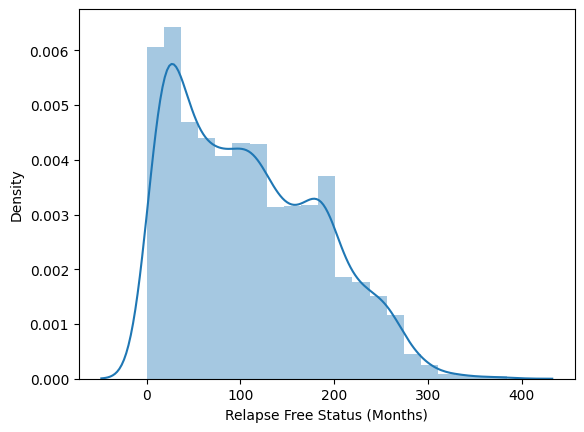

In [ ]:
sns.distplot(df['Relapse Free Status (Months)'])

<Axes: xlabel='count', ylabel='Relapse Free Status'>

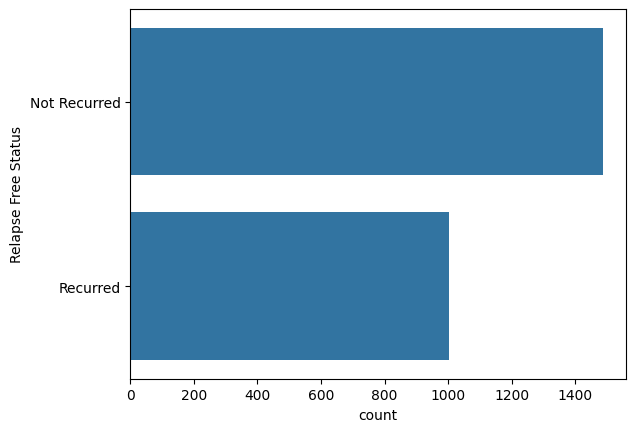

In [ ]:
sns.countplot(df['Relapse Free Status'])

In [ ]:
df = df.drop(['Patient ID', 'Cancer Type','Sex', 'Integrative Cluster', 'Patient\'s Vital Status'], axis = 1)

for col in df.select_dtypes(exclude='number').columns: # Select categorical data
  print(df[col].value_counts(),"\n")

Type of Breast Surgery
Mastectomy           1170
Breast Conserving     785
Name: count, dtype: int64 

Cancer Type Detailed
Breast Invasive Ductal Carcinoma             1865
Breast Mixed Ductal and Lobular Carcinoma     269
Breast Invasive Lobular Carcinoma             192
Invasive Breast Carcinoma                     133
Breast Invasive Mixed Mucinous Carcinoma       25
Breast                                         21
Breast Angiosarcoma                             2
Metaplastic Breast Cancer                       2
Name: count, dtype: int64 

Cellularity
High        965
Moderate    737
Low         215
Name: count, dtype: int64 

Chemotherapy
No     1568
Yes     412
Name: count, dtype: int64 

Pam50 + Claudin-low subtype
LumA           700
LumB           475
Her2           224
claudin-low    218
Basal          209
Normal         148
NC               6
Name: count, dtype: int64 

ER status measured by IHC
Positve     1817
Negative     609
Name: count, dtype: int64 

ER Status
Positive

<Axes: >

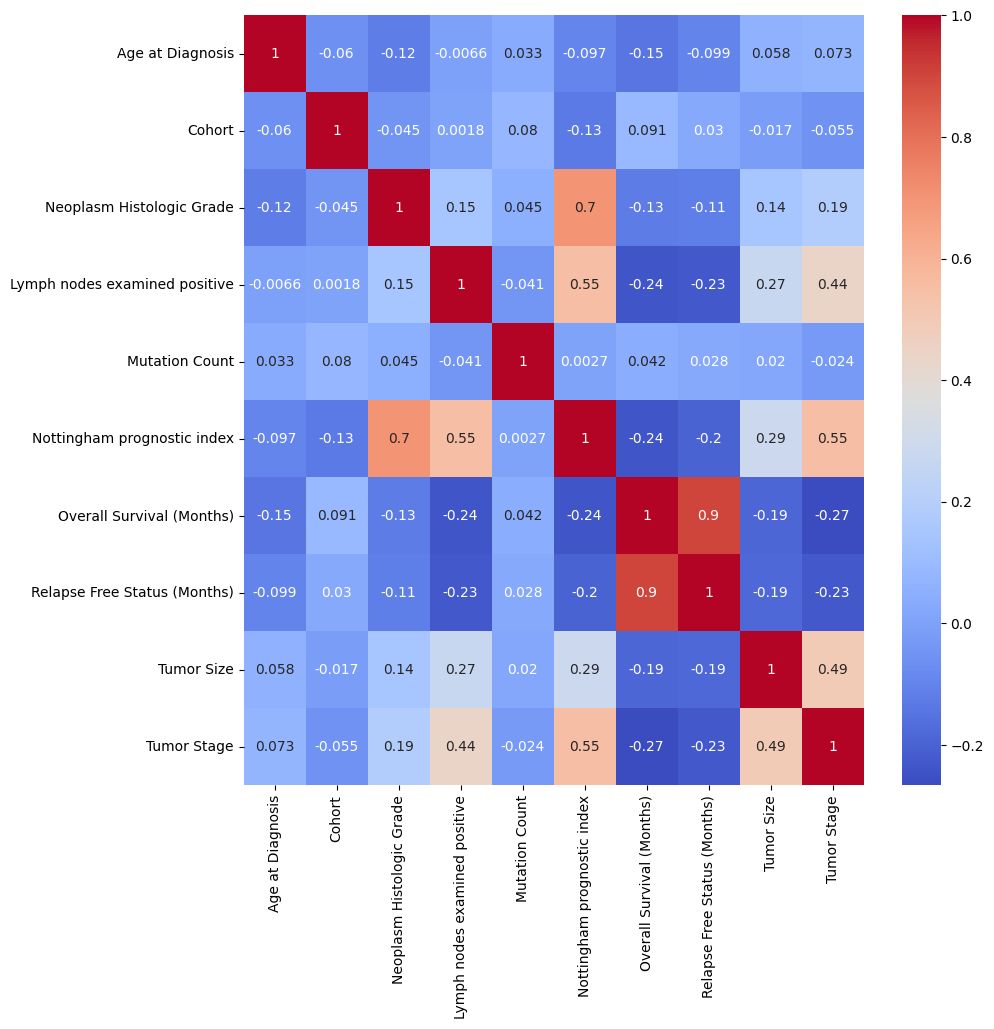

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

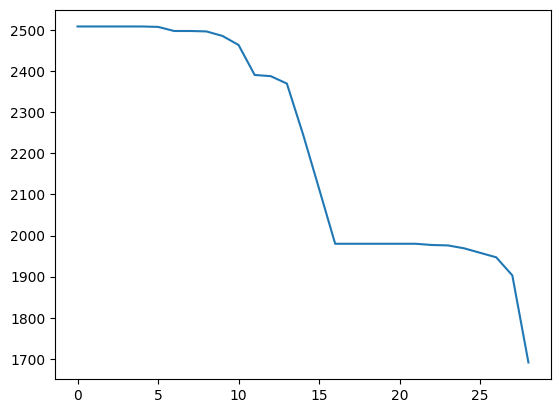

In [ ]:
nas = [df.dropna(thresh=i).shape[0] for i in range(0, df.shape[1])]

plt.plot(range(0, df.shape[1]), nas)
plt.show()

In [ ]:
df.isnull().sum()/(len(df)) # Proportion of missing data per column

,0
Age at Diagnosis,0.004384
Type of Breast Surgery,0.220805
Cancer Type Detailed,0.000000
Cellularity,0.235951
Chemotherapy,0.210841
Pam50 + Claudin-low subtype,0.210841
Cohort,0.004384
ER status measured by IHC,0.033081
ER Status,0.015943
Neoplasm Histologic Grade,0.048226


In [ ]:
df2 = df.dropna(subset=["Overall Survival (Months)"])
df3 = df.dropna(subset=["Relapse Free Status (Months)"])
df4 = df.dropna()
df5 = df4.copy()

In [ ]:
print(df.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(2509, 29)
(1981, 29)
(2388, 29)
(1092, 29)
(1092, 29)


In [ ]:
labels = ['Overall Survival Status','Relapse Free Status']

num = ['Age at Diagnosis', 'Cohort', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Tumor Size', 'Tumor Stage']

nom = ['Type of Breast Surgery', 'Cancer Type Detailed', 'Chemotherapy', 'Pam50 + Claudin-low subtype',
       'ER status measured by IHC', 'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
       'Hormone Therapy', 'Inferred Menopausal State', 'Primary Tumor Laterality', 'Oncotree Code',
       'PR Status', 'Radio Therapy', '3-Gene classifier subtype']
len(nom)

16

In [ ]:
df4.loc[:,num] = standardize(df4[num])

In [ ]:
df4.loc[:,'Cellularity'] = OrdinalEncoder(categories = [['Low', 'Moderate', 'High']]).fit_transform(df4[['Cellularity']])

In [ ]:
df4.loc[:,labels[0]] = LabelEncoder().fit_transform(df4[labels[0]])
df4.loc[:,labels[1]] = LabelEncoder().fit_transform(df4[labels[1]])

In [ ]:
enc = OneHotEncoder(drop = 'first')
ohe = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(df4[nom]))
ohe.columns = enc.get_feature_names_out(nom)

df4 = df4.drop(nom, axis = 1)
df4 = pd.concat([df4, ohe.set_index(df4.index)], axis = 1)

In [ ]:
df4.shape

(1092, 49)

In [ ]:
ohe.shape

(1092, 36)

In [ ]:
df4

,Age at Diagnosis,Cellularity,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),...,Primary Tumor Laterality_Right,Oncotree Code_IDC,Oncotree Code_ILC,Oncotree Code_IMMC,Oncotree Code_MDLC,PR Status_Positive,Radio Therapy_Yes,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+
1,-1.323253,2.0,-1.277707,0.870615,-0.490575,-0.910694,-0.102761,84.633333,1,83.52,...,1.0,1.0,0,0,0,1.0,1.0,0,0,0
4,1.275022,2.0,-1.277707,0.870615,1.586818,-0.910694,1.839802,41.366667,0,18.55,...,1.0,0,0,0,1.0,1.0,1.0,0,0,0
5,1.413474,1.0,-1.277707,0.870615,-0.490575,-0.386042,-0.063155,7.800000,0,2.89,...,0,1.0,0,0,0,1.0,1.0,0,0,0
10,2.001124,1.0,-1.277707,0.870615,-0.230901,-0.386042,0.851547,36.566667,0,36.09,...,1.0,1.0,0,0,0,0,1.0,0,0,0
11,1.832675,2.0,-1.277707,-0.700809,-0.490575,-0.123716,-1.011805,36.266667,0,35.79,...,0,0,1.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,0.832746,2.0,2.909107,-0.700809,0.548122,1.450240,0.877950,85.000000,0,83.88,...,0,0,0,0,1.0,1.0,0,1.0,0,0
1698,0.788903,2.0,2.909107,-2.272234,-0.490575,0.925588,-1.969885,201.166667,1,198.52,...,0,0,0,0,1.0,1.0,1.0,1.0,0,0
1700,1.171183,2.0,2.909107,0.870615,-0.490575,-0.386042,-0.083901,105.200000,0,103.82,...,1.0,1.0,0,0,0,0,0,0,1.0,0
1702,-0.580999,2.0,2.909107,-0.700809,1.067470,-0.123716,0.859090,200.333333,1,197.70,...,1.0,0,0,0,1.0,1.0,1.0,0,0,0


In [ ]:
df4.isnull().sum()/(len(df4))

<ipython-input-30-6d30eada5506>:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df4.isnull().sum()/(len(df4))


,0
Age at Diagnosis,0.0
Cellularity,0.0
Cohort,0.0
Neoplasm Histologic Grade,0.0
Lymph nodes examined positive,0.0
Mutation Count,0.0
Nottingham prognostic index,0.0
Overall Survival (Months),0.0
Overall Survival Status,0.0
Relapse Free Status (Months),0.0


In [ ]:
# df.dropna(subset=["Overall Survival (Months)"]).equals(df.dropna(subset=["Overall Survival Status"]))

In [ ]:
# df.dropna(subset=["Relapse Free Status (Months)"]).equals(df.dropna(subset=["Relapse Free Status"]))

In [ ]:
df_surv = df4.drop(['Relapse Free Status (Months)', 'Relapse Free Status'], axis = 1)
df_relapse = df4.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis = 1)

x_surv = df_surv.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis = 1).to_numpy()
# x_surv = df_surv.drop(['Overall Survival (Months)', 'Overall Survival Status', 'Patient's Vital Status_Died of Disease',
#                        'Patient's Vital Status_Died of Other Causes', 'Patient's Vital Status_Living'], axis = 1).to_numpy()

feat_names = df_surv.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis = 1).columns

y_surv = Surv().from_dataframe('Overall Survival Status', 'Overall Survival (Months)', df_surv)

In [ ]:
df4['Overall Survival Status'].unique()

array([1, 0], dtype=object)

In [ ]:
print(x_surv.shape)
print(y_surv.shape)

(1092, 45)
(1092,)


In [ ]:
y_surv

array([( True,  84.63333333), (False,  41.36666667),
       (False,   7.8       ), ..., (False, 105.2       ),
       ( True, 200.3333333 ), ( True, 281.5       )],
      dtype=[('Overall Survival Status', '?'), ('Overall Survival (Months)', '<f8')])

# Survival Analysis


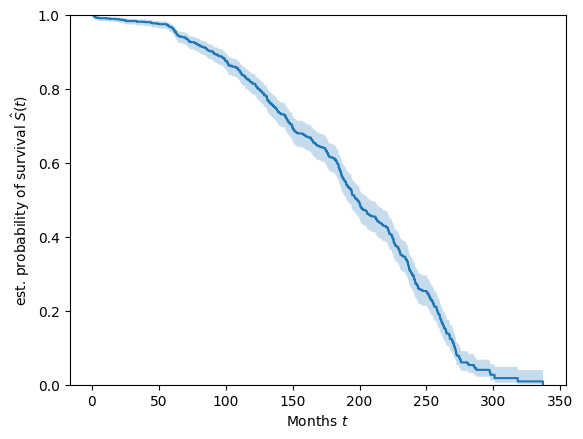

In [ ]:
time, prob, conf_int = kaplan_meier_estimator(y_surv['Overall Survival Status'], y_surv['Overall Survival (Months)'], conf_type="log-log")
plt.step(time, prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("Months $t$")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_surv, y_surv, test_size=0.2, stratify = y_surv['Overall Survival Status'], random_state=0) # splitting data

cox = CoxPHSurvivalAnalysis(alpha = 0.00000001).fit(x_train, y_train)
cox_pred = cox.predict(x_test)

In [ ]:
pd.set_option('display.max_rows', 65)
pd.Series(cox.coef_, feat_names)

,0
Age at Diagnosis,0.066086
Cellularity,-0.070014
Cohort,-0.497392
Neoplasm Histologic Grade,0.138635
Lymph nodes examined positive,0.079845
Mutation Count,-0.141548
Nottingham prognostic index,-0.359309
Tumor Size,-0.004007
Tumor Stage,0.076158
Type of Breast Surgery_Mastectomy,-0.051587


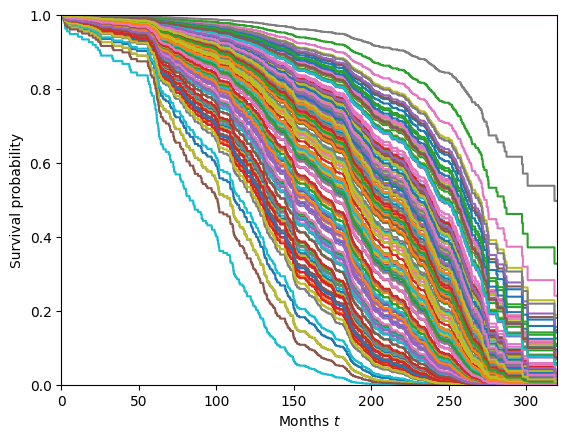

In [ ]:
# Survival Function
pred_func = cox.predict_survival_function(x_test)
for fn in pred_func:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,1)
plt.xlim(0,320)
plt.ylabel("Survival probability")
plt.xlabel("Months $t$")
plt.show()

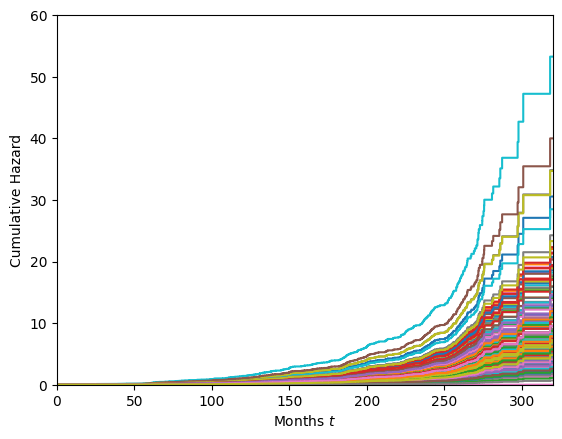

In [ ]:
# Cumulative Hazard Function
cum_h = cox.predict_cumulative_hazard_function(x_test)
for fn in cum_h:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,60)
plt.xlim(0,320)
plt.ylabel("Cumulative Hazard")
plt.xlabel("Months $t$")
plt.show()

In [ ]:
cox.score(x_test, y_test)

0.715788054469462

In [ ]:
times = np.percentile(y_surv['Overall Survival (Months)'], np.linspace(10, 90, 10))

In [ ]:
surv = np.asarray([[fn(i) for i in times] for fn in cox.predict_survival_function(x_test)])
integrated_brier_score(y_train, y_test, surv, times)

0.1208205716548286

In [ ]:
st_auc, st_mean_auc = cumulative_dynamic_auc(y_train, y_test, cox_pred, times)
print(st_auc)
print(st_mean_auc)

[0.75       0.75852273 0.83131314 0.84482775 0.77158433 0.7802191
 0.84169202 0.79890586 0.73182246 0.69219895]
0.7615460694008348


Text(0.5, 0, 'Months $t$')

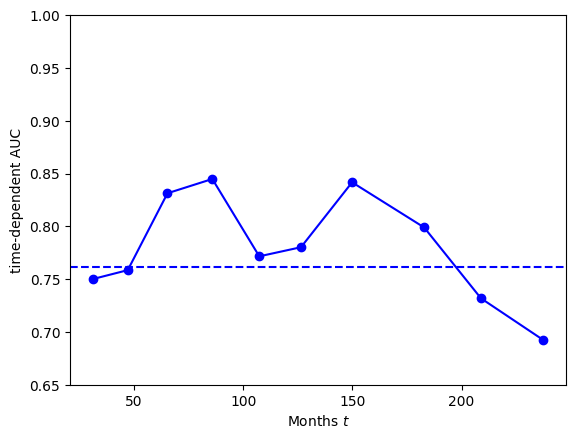

In [ ]:
plt.plot(times, st_auc, marker = 'o', color = 'b')
plt.axhline(st_mean_auc, linestyle="--", color = 'b')
plt.ylim(0.65,1)
plt.ylabel("time-dependent AUC")
plt.xlabel("Months $t$")

In [ ]:
def scores(X, y):
    scores = np.empty(X.shape[1])
    m = CoxPHSurvivalAnalysis()
    for j in range(X.shape[1]):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

pd.Series(scores(x_train, y_train), index=feat_names).sort_values(ascending=False)

,0
Cohort,0.677704
Mutation Count,0.612564
Hormone Therapy_Yes,0.578156
Tumor Stage,0.554470
Chemotherapy_Yes,0.552463
Radio Therapy_Yes,0.546204
Primary Tumor Laterality_Right,0.533041
Tumor Size,0.528651
Nottingham prognostic index,0.526868
HER2 status measured by SNP6_Neutral,0.526080


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("select", SelectKBest(scores, k=3)),
        ("model", CoxPHSurvivalAnalysis(alpha = 0.001)),
    ]
)
param_grid = {"select__k": np.arange(2, 7)}
cv = KFold(n_splits=5, random_state=0, shuffle=True)

In [ ]:
gcv = GridSearchCV(pipe,
                   param_grid,
                   return_train_score=True,
                   cv=cv,
                   n_jobs = -1).fit(x_train, y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/sklea

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2,{'select__k': 2},0.564570,0.624858,0.714926,0.679173,NaN,NaN,NaN,1,0.698617,0.686232,0.663517,0.674498,NaN,NaN,NaN
1,3,{'select__k': 3},0.540386,0.632939,0.702707,0.692316,NaN,NaN,NaN,1,0.706985,0.685616,0.670411,0.672355,NaN,NaN,NaN
2,4,{'select__k': 4},0.540505,0.626793,0.701477,0.686475,NaN,NaN,NaN,1,0.705711,0.687334,0.673484,0.676772,NaN,NaN,NaN
3,5,{'select__k': 5},0.560281,0.634760,0.704817,0.689059,NaN,NaN,NaN,1,0.701744,0.692210,0.676065,0.677422,NaN,NaN,NaN
4,6,{'select__k': 6},0.555397,0.640565,0.693917,0.691530,NaN,NaN,NaN,1,0.705044,0.689482,0.677478,0.679633,NaN,NaN,NaN


In [ ]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coef = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(x_train, y_train)
    key = round(alpha, 5)
    coef[key] = cph.coef_

coef = pd.DataFrame.from_dict(coef).rename_axis(index="feature", columns="alpha").set_index(feat_names)
coef

alpha,0.00010,0.00015,0.00021,0.00031,0.00045,0.00066,0.00095,0.00139,0.00202,0.00295,...,339.32218,494.17134,719.68567,1048.11313,1526.41797,2222.99648,3237.45754,4714.86636,6866.48845,10000.00000
Age at Diagnosis,0.066083,0.066082,0.066081,0.066079,0.066076,0.066073,0.066068,0.066060,0.066051,0.066037,...,-0.015164,-0.015595,-0.014654,-0.012805,-0.010550,-0.008295,-0.006289,-0.004638,-0.003351,-0.002385
Cellularity,-0.070003,-0.069999,-0.069994,-0.069987,-0.069977,-0.069963,-0.069946,-0.069922,-0.069891,-0.069850,...,-0.039569,-0.029718,-0.021688,-0.015494,-0.010907,-0.007605,-0.005271,-0.003640,-0.002509,-0.001727
Cohort,-0.497394,-0.497395,-0.497396,-0.497398,-0.497400,-0.497404,-0.497408,-0.497414,-0.497421,-0.497432,...,-0.247243,-0.199730,-0.156356,-0.118974,-0.088349,-0.064311,-0.046084,-0.032629,-0.022899,-0.015967
Neoplasm Histologic Grade,0.138635,0.138635,0.138635,0.138636,0.138636,0.138636,0.138636,0.138636,0.138635,0.138633,...,-0.013586,-0.011474,-0.008835,-0.006306,-0.004243,-0.002740,-0.001728,-0.001080,-0.000678,-0.000430
Lymph nodes examined positive,0.079850,0.079852,0.079855,0.079858,0.079863,0.079869,0.079877,0.079887,0.079901,0.079918,...,0.019846,0.018549,0.016295,0.013564,0.010790,0.008274,0.006162,0.004488,0.003214,0.002274
Mutation Count,-0.141547,-0.141546,-0.141546,-0.141545,-0.141544,-0.141543,-0.141542,-0.141540,-0.141538,-0.141535,...,-0.110032,-0.093368,-0.076636,-0.060957,-0.047113,-0.035502,-0.026179,-0.018963,-0.013543,-0.009567
Nottingham prognostic index,-0.359311,-0.359312,-0.359313,-0.359314,-0.359315,-0.359316,-0.359317,-0.359319,-0.359319,-0.359318,...,-0.002611,0.002960,0.005903,0.006926,0.006715,0.005848,0.004745,0.003665,0.002734,0.001989
Tumor Size,-0.004005,-0.004004,-0.004002,-0.004000,-0.003998,-0.003994,-0.003989,-0.003982,-0.003972,-0.003959,...,0.015770,0.013014,0.010669,0.008621,0.006817,0.005255,0.003951,0.002905,0.002098,0.001494
Tumor Stage,0.076152,0.076150,0.076147,0.076143,0.076137,0.076130,0.076120,0.076106,0.076088,0.076064,...,0.037090,0.033662,0.029244,0.024326,0.019440,0.015003,0.011247,0.008238,0.005927,0.004207
Type of Breast Surgery_Mastectomy,-0.051597,-0.051601,-0.051606,-0.051614,-0.051624,-0.051637,-0.051655,-0.051679,-0.051711,-0.051753,...,-0.021899,-0.015799,-0.011009,-0.007480,-0.005003,-0.003321,-0.002203,-0.001465,-0.000980,-0.000659


KeyError: ('Pam50 + Claudin-low subtype_Her2', 0.0001)

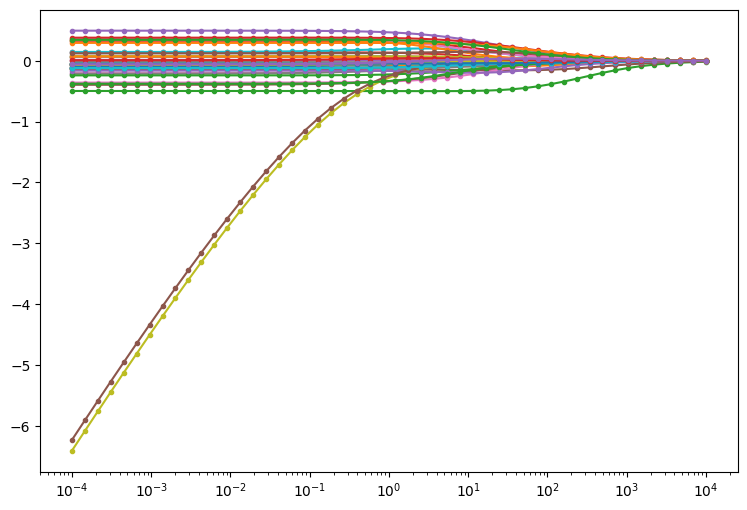

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
for row in coef.itertuples():
    ax.semilogx(alphas, row[1:], ".-", label=row.Index)

for name in coef.loc[:, alphas[0]].map(abs).sort_values().tail(5).index:
    coef = coef[name, alphas[0]]
    plt.text(alphas[0], coef, name + "   ", horizontalalignment="right", verticalalignment="center")

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.grid(True)
ax.set_xlabel("alpha")
ax.set_ylabel("coefficient")

In [ ]:
coef.loc[:, alphas[0]].map(abs).sort_values().tail(5).index

Index(['Pam50 + Claudin-low subtype_Her2', 'Chemotherapy_Yes', 'Cohort',
       'HER2 status measured by SNP6_Undef', 'Pam50 + Claudin-low subtype_NC'],
      dtype='object')

In [ ]:
def plot_logrank(feat):
  for value in df5[feat].unique():
    mask = df5[feat] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y_surv['Overall Survival Status'][mask], y_surv['Overall Survival (Months)'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
  plt.ylim(0, 1)
  plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
  plt.xlabel("Months $t$")
  plt.legend(loc="best")

In [ ]:
compare_survival(y_surv, df5.loc[:,'Hormone Therapy'])

(19.874133894020524, 8.271189650121358e-06)

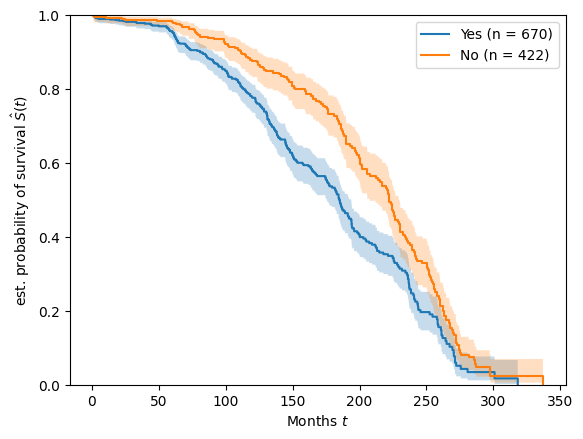

In [ ]:
plot_logrank('Hormone Therapy')

In [ ]:
compare_survival(y_surv, df5.loc[:,'Chemotherapy'])

(36.52974614322031, 1.503541545786676e-09)

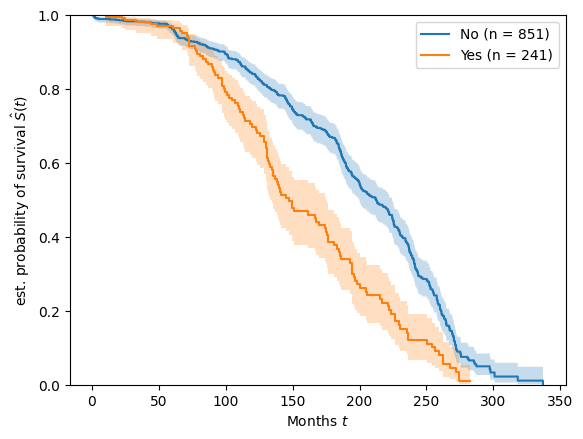

In [ ]:
plot_logrank('Chemotherapy')

In [ ]:
compare_survival(y_surv, df5.loc[:,'Radio Therapy'])

(18.002714393820757, 2.2059020581771334e-05)

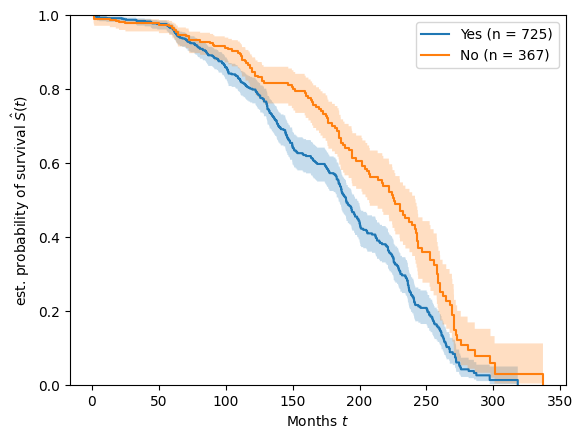

In [ ]:
plot_logrank('Radio Therapy')

In [ ]:
compare_survival(y_surv, df5.loc[:,'Primary Tumor Laterality'])

(7.4670514665002194, 0.0062838383585236)

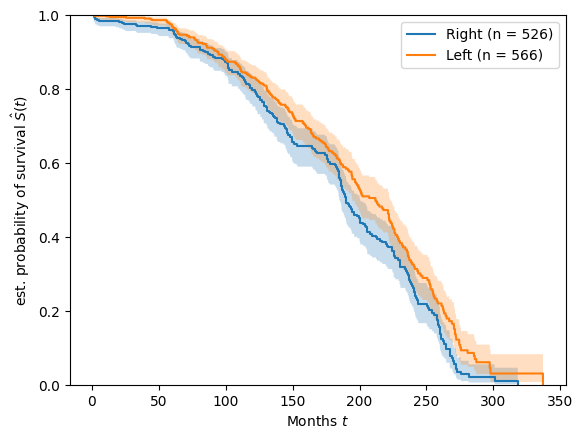

In [ ]:
plot_logrank('Primary Tumor Laterality')

In [ ]:
compare_survival(y_surv, df5.loc[:,'HER2 status measured by SNP6'])

(10.738030634306863, 0.013230158974048351)

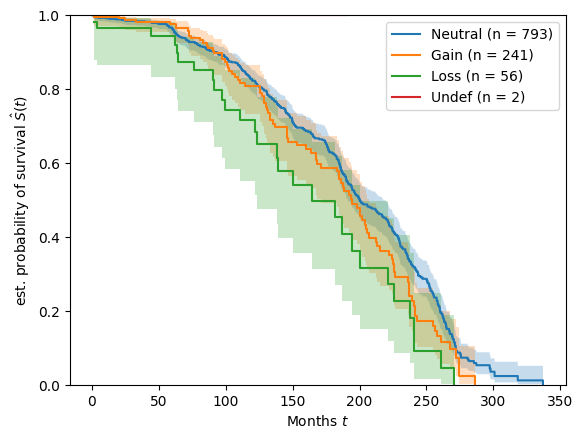

In [ ]:
plot_logrank('HER2 status measured by SNP6')

# Decision Tree

In [ ]:
mod = SurvivalTree(random_state = 0).fit(x_train, y_train)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

params = {
    'estimator__max_depth': range(2,10),
    'estimator__min_samples_leaf': [30 ,40 ,50, 60, 70, 80, 90, 100],
}

In [ ]:
x_train.shape

(873, 45)

In [ ]:
x_test.shape

(219, 45)

In [ ]:
times

array([ 31.04333333,  47.15666666,  65.33703703,  85.87      ,
       107.36777781, 126.46592596, 149.86333337, 182.86296296,
       208.86296299, 237.48666667])

In [ ]:
gcv_brier = GridSearchCV(
    as_integrated_brier_score_scorer(mod, times=times),
    param_grid= params,
    cv=cv,
    n_jobs= -1,
).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
print(gcv_brier.best_params_)
print(gcv_brier.best_score_)

{'estimator__max_depth': 2, 'estimator__min_samples_leaf': 30}
nan


In [ ]:
gcv_ci = GridSearchCV(
    as_concordance_index_ipcw_scorer(mod, tau=times[-1]),
    param_grid= params,
    cv=cv,
    n_jobs=-1,
).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print(gcv_ci.best_params_)
print(gcv_ci.best_score_)

{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 40}
0.7146661124809064


In [ ]:
gcv_auc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(mod, times=times),
    param_grid= params,
    cv=cv,
    n_jobs=-1,
).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
print(gcv_auc.best_params_)
print(gcv_auc.best_score_)

{'estimator__max_depth': 2, 'estimator__min_samples_leaf': 30}
nan


In [ ]:
st = SurvivalTree(max_depth = 8, min_samples_leaf = 40, random_state = 0).fit(x_train, y_train)
st_pred = st.predict(x_test)

In [ ]:
len(set(st_pred))

17

In [ ]:
np.unique(st_pred)

array([ 44.03240741,  79.40675187,  95.38144781, 141.48724891,
       172.2163566 , 172.39951072, 182.08159269, 207.68013102,
       213.35405721, 244.82203639, 305.4892341 , 312.15215528,
       379.22446204, 641.36948945, 735.77145942, 792.9082835 ,
       906.7178338 ])

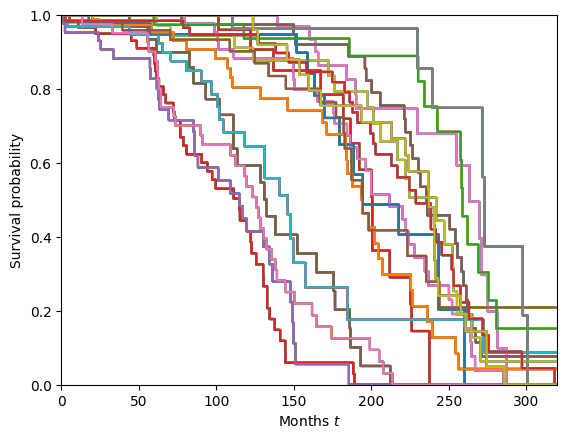

In [ ]:
# Survival Function
pred_func = st.predict_survival_function(x_test)
for fn in pred_func:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,1)
plt.xlim(0,320)
plt.ylabel("Survival probability")
plt.xlabel("Months $t$")
plt.show()

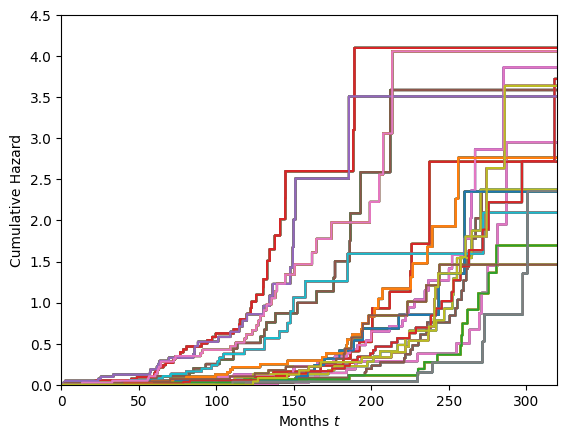

In [ ]:
# Cumulative Hazard Function
cum_h = st.predict_cumulative_hazard_function(x_test)
for fn in cum_h:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,4.5)
plt.xlim(0,320)
plt.ylabel("Cumulative Hazard")
plt.xlabel("Months $t$")
plt.show()

In [ ]:
st.score(x_test, y_test)

0.7156532290683565

In [ ]:
concordance_index_ipcw(y_train, y_test, st_pred, times[-1])

(0.6845603493193351, 5105, 1906, 406, 0)

In [ ]:
surv = np.asarray([[fn(i) for i in times] for fn in st.predict_survival_function(x_test)])
integrated_brier_score(y_train, y_test, surv, times)

0.11133609505080408

In [ ]:
st_auc, st_mean_auc = cumulative_dynamic_auc(y_train, y_test, st_pred, times)
print(st_auc)
print(st_mean_auc)

[0.82954545 0.83664773 0.86444873 0.85855281 0.72682396 0.75216219
 0.81112298 0.77902625 0.81489486 0.71278429]
0.7679930783485794


Text(0.5, 0, 'Months $t$')

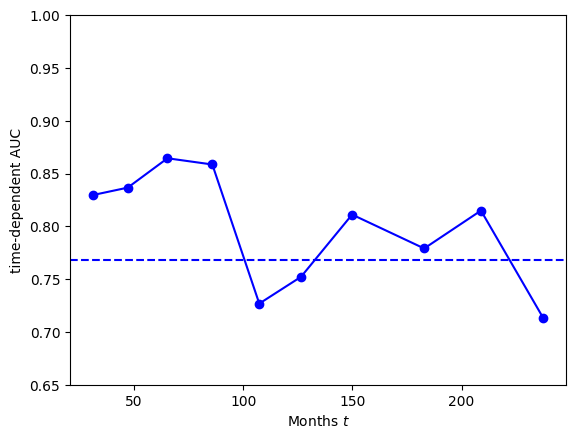

In [ ]:
plt.plot(times, st_auc, marker = 'o', color = 'b')
plt.axhline(st_mean_auc, linestyle="--", color = 'b')
plt.ylim(0.65,1)
plt.ylabel("time-dependent AUC")
plt.xlabel("Months $t$")

# Random Forest

In [ ]:
mod2 = RandomSurvivalForest(random_state = 0, n_jobs = -1)

params = {
    'estimator__max_depth': range(2,8),
    'estimator__min_samples_leaf': [10, 20, 30 ,40 ,50, 60, 70, 80],
}

In [ ]:
gcv_brier = GridSearchCV(
    as_integrated_brier_score_scorer(mod2, times=times),
    param_grid= params,
    cv=cv,
    n_jobs = 1
).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py", line 805, in score
    score = self._score_func(
  File "/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py", line 737, in integrated_brier_score
    times, brier_scores = brier_score(survival_train, survival_test, estimate, times)
  File "/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py", line 621, in brier_score
    prob_cens_y = cens.predict_proba(test_time)

In [ ]:
print(gcv_brier.best_params_)
print(gcv_brier.best_score_)

{'estimator__max_depth': 2, 'estimator__min_samples_leaf': 10}
nan


In [ ]:
gcv_ci = GridSearchCV(
    as_concordance_index_ipcw_scorer(mod2, tau=times[-1]),
    param_grid= params,
    cv=cv,
    n_jobs=1,
).fit(x_train, y_train)

In [ ]:
print(gcv_ci.best_params_)
print(gcv_ci.best_score_)

{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 10}
0.7087318635240486


In [ ]:
gcv_auc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(mod2, times=times),
    param_grid= params,
    cv=cv,
    n_jobs=1,
).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py", line 805, in score
    score = self._score_func(
  File "/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py", line 459, in cumulative_dynamic_auc
    ipcw = cens.predict_ipcw(survival_test)
  File "/usr/local/lib/python3.10/dist-packages/sksurv/nonparametric.py", line 580, in predict_ipcw
    Ghat = self.predict_proba(time[event])
  File "/usr/local/lib/python3.10/dist-

In [ ]:
print(gcv_auc.best_params_)
print(gcv_auc.best_score_)

{'estimator__max_depth': 2, 'estimator__min_samples_leaf': 10}
nan


In [ ]:
rsf = RandomSurvivalForest(max_depth = 6, min_samples_leaf= 10, n_jobs = -1).fit(x_train, y_train)
rsf_pred = rsf.predict(x_test)

In [ ]:
len(set(rsf_pred))

219

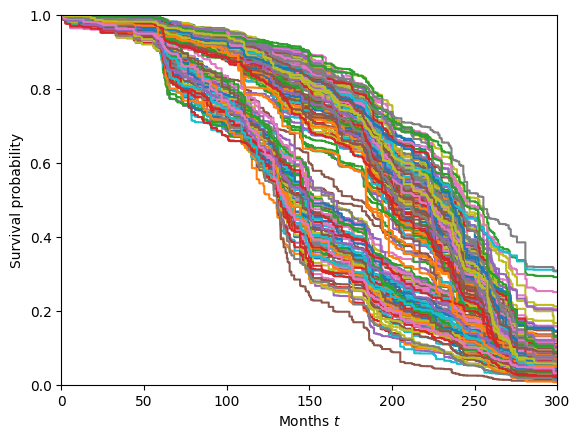

In [ ]:
# Survival Function
pred2 = rsf.predict_survival_function(x_test)
for fn in pred2:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,1)
plt.xlim(0,300)
plt.ylabel("Survival probability")
plt.xlabel("Months $t$")
plt.show()

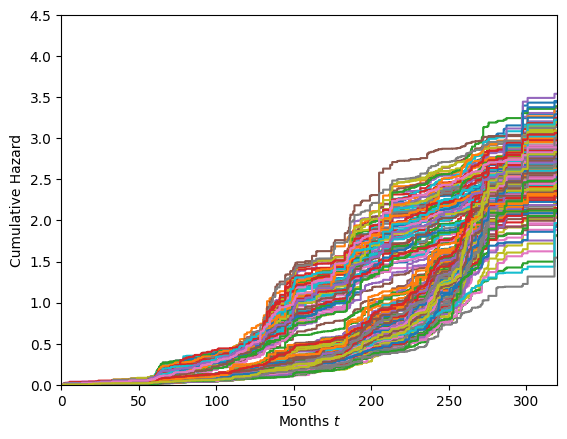

In [ ]:
# Cumulative Hazard Function
cum_h = rsf.predict_cumulative_hazard_function(x_test)
for fn in cum_h:
  plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0,4.5)
plt.xlim(0,320)
plt.ylabel("Cumulative Hazard")
plt.xlabel("Months $t$")
plt.show()

In [ ]:
rsf.score(x_test, y_test)

0.7556963731967102

In [ ]:
concordance_index_ipcw(y_train, y_test, rsf_pred, times[-1])

(0.735778333947782, 5605, 1812, 0, 0)

In [ ]:
surv = np.asarray([[fn(i) for i in times] for fn in rsf.predict_survival_function(x_test)])
integrated_brier_score(y_train, y_test, surv, times)

0.1078388824885356

In [ ]:
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_pred, times)
print(rsf_auc)
print(rsf_mean_auc)

[0.73989899 0.73863636 0.82316538 0.87914425 0.80548469 0.78863459
 0.84296756 0.84850156 0.81151824 0.80988521]
0.8181329165934238


Text(0.5, 0, 'Months $t$')

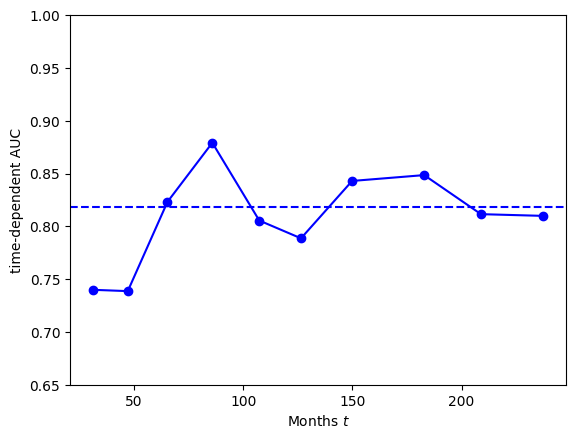

In [ ]:
plt.plot(times, rsf_auc, marker = 'o', color = 'b')
plt.axhline(rsf_mean_auc, linestyle="--", color = 'b')
plt.ylim(0.65,1)
plt.ylabel("time-dependent AUC")
plt.xlabel("Months $t$")

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, x_test, y_test, n_repeats=15, random_state=0)
pd.DataFrame({k: result[k]for k in ("importances_mean","importances_std",)},index=feat_names,).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Cohort,0.173233,0.023901
Hormone Therapy_Yes,0.011999,0.007818
Nottingham prognostic index,0.007982,0.005699
Age at Diagnosis,0.007514,0.003328
Chemotherapy_Yes,0.005528,0.008137
Pam50 + Claudin-low subtype_LumA,0.004899,0.001824
Tumor Stage,0.003955,0.002190
Type of Breast Surgery_Mastectomy,0.003784,0.001758
Tumor Size,0.003568,0.002902
Radio Therapy_Yes,0.002508,0.002876


# SVM

In [ ]:
fsvm = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
param_grid = {"alpha": 2.0**np.linspace(-4, 2, 10)}

In [ ]:
def scoring(mod, x, y):
    return concordance_index_ipcw(y_surv['Overall Survival Status'], y_surv['Overall Survival (Months)'], mod.predict(x))[0]

In [ ]:
gcv_fsvm = GridSearchCV(fsvm,
                        param_grid,
                        scoring = scoring,
                        n_jobs=-1,
                        cv=cv).fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
print(gcv_fsvm.best_params_)
print(gcv_fsvm.best_score_)

{'alpha': 0.0625}
nan


In [ ]:
fsvm = FastSurvivalSVM(alpha = 0.0625, max_iter=1000, tol=1e-5, random_state=0).fit(x_train, y_train)
fsvm_pred = fsvm.predict(x_test)

In [ ]:
len(set(fsvm_pred))

219

In [ ]:
fsvm_pred

array([ 0.33914424, -0.22098629,  0.22343727, -0.36220253,  0.41280692,
        0.29437065, -1.1052245 , -0.4785032 ,  0.19337774, -0.00819056,
       -0.25126845,  0.27691034,  0.51500199,  0.38264071, -0.32646246,
       -0.0167351 , -0.07222169, -0.09616944, -0.29426842, -0.30155899,
       -0.50787978,  0.24000058,  0.14456161,  0.39042247, -0.11730459,
       -0.37226155,  0.34294885,  0.25130931,  0.3581177 , -0.17852688,
       -0.1938587 , -0.10010688, -0.3737925 ,  0.48297518,  0.13010312,
       -0.09756845,  0.19086198, -0.17296831, -0.64987666, -0.09582398,
        0.79043368,  0.11992714, -0.02660347, -0.33950494,  0.04737046,
       -0.22061765, -0.69168416, -0.22179858,  0.05244006,  0.41297605,
        0.32578313,  0.22296744, -0.25015668,  0.27381234,  0.25281103,
        0.28877795, -0.12964677, -0.24025853, -0.12185038,  0.94422686,
       -0.06569211, -0.19628226, -0.08173213, -0.22881438, -0.44899097,
        0.52954093, -0.38355006, -0.27944496,  0.13066407, -0.06

In [ ]:
fsvm.score(x_test, y_test)

0.7206417689092625

In [ ]:
concordance_index_ipcw(y_train, y_test, fsvm_pred, times[-1])

(0.6806099481130774, 5345, 2072, 0, 0)

In [ ]:
fsvm_auc, fsvm_mean_auc = cumulative_dynamic_auc(y_train, y_test, fsvm_pred, times)
print(fsvm_auc)
print(fsvm_mean_auc)

[0.81818182 0.82102273 0.86148041 0.85100437 0.77058296 0.77238214
 0.84205771 0.79384604 0.71889873 0.69502242]
0.7602102383631608


Text(0.5, 0, 'Months $t$')

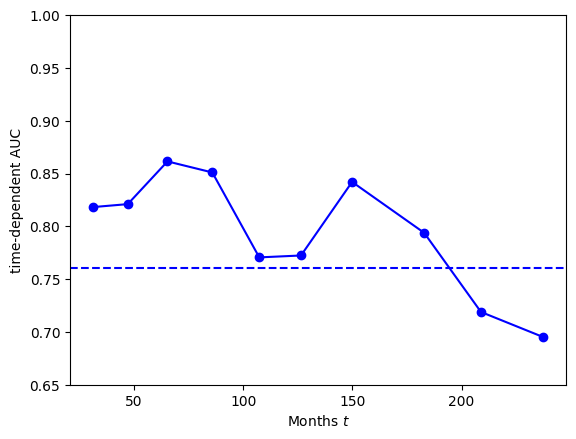

In [ ]:
plt.plot(times, fsvm_auc, marker = 'o', color = 'b')
plt.axhline(fsvm_mean_auc, linestyle="--", color = 'b')
plt.ylim(0.65,1)
plt.ylabel("time-dependent AUC")
plt.xlabel("Months $t$")

# Plotting Tree (func)

In [ ]:
"""
This module defines export functions for survival trees.

It is based on the sklearn.tree.export module.
"""

# Authors: Gilles Louppe <g.louppe@gmail.com>
#          Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Brian Holt <bdholt1@gmail.com>
#          Noel Dawe <noel@dawe.me>
#          Satrajit Gosh <satrajit.ghosh@gmail.com>
#          Trevor Stephens <trev.stephens@gmail.com>
#          Li Li <aiki.nogard@gmail.com>
#          Giuseppe Vettigli <vettigli@gmail.com>
# License: BSD 3 clause
import warnings

from numbers import Integral

import numpy as np

from sklearn.tree import _criterion
from sklearn.tree import _tree
from sklearn.tree._reingold_tilford import buchheim, Tree
from sklearn.tree import DecisionTreeClassifier
from sksurv.tree import SurvivalTree
from sksurv.tree._criterion import LogrankCriterion


def _color_brew(n):
    """Generate n colors with equally spaced hues.

    Parameters
    ----------
    n : int
        The number of colors required.

    Returns
    -------
    color_list : list, length n
        List of n tuples of form (R, G, B) being the components of each color.
    """
    color_list = []

    # Initialize saturation & value; calculate chroma & value shift
    s, v = 0.75, 0.9
    c = s * v
    m = v - c

    for h in np.arange(25, 385, 360. / n).astype(int):
        # Calculate some intermediate values
        h_bar = h / 60.
        x = c * (1 - abs((h_bar % 2) - 1))
        # Initialize RGB with same hue & chroma as our color
        rgb = [(c, x, 0),
               (x, c, 0),
               (0, c, x),
               (0, x, c),
               (x, 0, c),
               (c, 0, x),
               (c, x, 0)]
        r, g, b = rgb[int(h_bar)]
        # Shift the initial RGB values to match value and store
        rgb = [(int(255 * (r + m))),
               (int(255 * (g + m))),
               (int(255 * (b + m)))]
        color_list.append(rgb)

    return color_list


def plot_tree(decision_tree, max_depth=None, feature_names=None,
              class_names=None, label='all', filled=False,
              impurity=True, node_ids=False,
              proportion=False, rotate=False, rounded=False,
              precision=3, ax=None, fontsize=None):
    """Plot a decision tree.

    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    This function requires matplotlib, and works best with matplotlib >= 1.5.

    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.

    Read more in the :ref:`User Guide <tree>`.

    .. versionadded:: 0.21

    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be exported to GraphViz.

    max_depth : int, optional (default=None)
        The maximum depth of the representation. If None, the tree is fully
        generated.

    feature_names : list of strings, optional (default=None)
        Names of each of the features.

    class_names : list of strings, bool or None, optional (default=None)
        Names of each of the target classes in ascending numerical order.
        Only relevant for classification and not supported for multi-output.
        If ``True``, shows a symbolic representation of the class name.

    label : {'all', 'root', 'none'}, optional (default='all')
        Whether to show informative labels for impurity, etc.
        Options include 'all' to show at every node, 'root' to show only at
        the top root node, or 'none' to not show at any node.

    filled : bool, optional (default=False)
        When set to ``True``, paint nodes to indicate majority class for
        classification, extremity of values for regression, or purity of node
        for multi-output.

    impurity : bool, optional (default=True)
        When set to ``True``, show the impurity at each node.

    node_ids : bool, optional (default=False)
        When set to ``True``, show the ID number on each node.

    proportion : bool, optional (default=False)
        When set to ``True``, change the display of 'values' and/or 'samples'
        to be proportions and percentages respectively.

    rotate : bool, optional (default=False)
        When set to ``True``, orient tree left to right rather than top-down.

    rounded : bool, optional (default=False)
        When set to ``True``, draw node boxes with rounded corners and use
        Helvetica fonts instead of Times-Roman.

    precision : int, optional (default=3)
        Number of digits of precision for floating point in the values of
        impurity, threshold and value attributes of each node.

    ax : matplotlib axis, optional (default=None)
        Axes to plot to. If None, use current axis. Any previous content
        is cleared.

    fontsize : int, optional (default=None)
        Size of text font. If None, determined automatically to fit figure.

    Returns
    -------
    annotations : list of artists
        List containing the artists for the annotation boxes making up the
        tree.

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn import tree

    >>> clf = tree.DecisionTreeClassifier(random_state=0)
    >>> iris = load_iris()

    >>> clf = clf.fit(iris.data, iris.target)
    >>> tree.plot_tree(clf)  # doctest: +SKIP
    [Text(251.5,345.217,'X[3] <= 0.8...

    """
    exporter = _MPLTreeExporter(
        max_depth=max_depth, feature_names=feature_names,
        class_names=class_names, label=label, filled=filled,
        impurity=impurity, node_ids=node_ids,
        proportion=proportion, rotate=rotate, rounded=rounded,
        precision=precision, fontsize=fontsize)
    return exporter.export(decision_tree, ax=ax)


class _BaseTreeExporter(object):
    def __init__(self, max_depth=None, feature_names=None,
                 class_names=None, label='all', filled=False,
                 impurity=True, node_ids=False,
                 proportion=False, rotate=False, rounded=False,
                 precision=3, fontsize=None):
        self.max_depth = max_depth
        self.feature_names = feature_names
        self.class_names = class_names
        self.label = label
        self.filled = filled
        self.impurity = impurity
        self.node_ids = node_ids
        self.proportion = proportion
        self.rotate = rotate
        self.rounded = rounded
        self.precision = precision
        self.fontsize = fontsize

    def get_color(self, value):
        # Find the appropriate color & intensity for a node
        if self.colors['bounds'] is None:
            # Classification tree
            color = list(self.colors['rgb'][np.argmax(value)])
            sorted_values = sorted(value, reverse=True)
            if len(sorted_values) == 1:
                alpha = 0
            else:
                alpha = ((sorted_values[0] - sorted_values[1])
                         / (1 - sorted_values[1]))
        else:
            # Regression tree or multi-output
            color = list(self.colors['rgb'][0])
            alpha = ((value - self.colors['bounds'][0]) /
                     (self.colors['bounds'][1] - self.colors['bounds'][0]))
        # unpack numpy scalars
        alpha = float(alpha)
        # compute the color as alpha against white
        color = [int(round(alpha * c + (1 - alpha) * 255, 0)) for c in color]
        # Return html color code in #RRGGBB format
        return '#%2x%2x%2x' % tuple(color)

    def get_fill_color(self, tree, node_id):
        # Fetch appropriate color for node
        if 'rgb' not in self.colors:
            # Initialize colors and bounds if required
            self.colors['rgb'] = _color_brew(tree.n_classes[0])
            if tree.n_outputs != 1:
                # Find max and min impurities for multi-output
                self.colors['bounds'] = (np.min(-tree.impurity),
                                         np.max(-tree.impurity))
            elif (tree.n_classes[0] == 1 and
                  len(np.unique(tree.value)) != 1):
                # Find max and min values in leaf nodes for regression
                self.colors['bounds'] = (np.min(tree.value),
                                         np.max(tree.value))
        if tree.n_outputs == 1:
            node_val = (tree.value[node_id][0, :] /
                        tree.weighted_n_node_samples[node_id])
            if tree.n_classes[0] == 1:
                # Regression
                node_val = tree.value[node_id][0, :]
        else:
            # If multi-output color node by impurity
            node_val = -tree.impurity[node_id]
        return self.get_color(node_val)

    def node_to_str(self, tree, node_id, criterion):
        # Generate the node content string
        if tree.n_outputs == 1:
            value = tree.value[node_id][0, :]
        else:
            value = tree.value[node_id]

        # Should labels be shown?
        labels = (self.label == 'root' and node_id == 0) or self.label == 'all'

        characters = self.characters
        node_string = characters[-1]

        # Write node ID
        if self.node_ids:
            if labels:
                node_string += 'node '
            node_string += characters[0] + str(node_id) + characters[4]

        # Write decision criteria
        if tree.children_left[node_id] != _tree.TREE_LEAF:
            # Always write node decision criteria, except for leaves
            if self.feature_names is not None:
                feature = self.feature_names[tree.feature[node_id]]
            else:
                feature = "X%s%s%s" % (characters[1],
                                       tree.feature[node_id],
                                       characters[2])
            node_string += '%s %s %s%s' % (feature,
                                           characters[3],
                                           round(tree.threshold[node_id],
                                                 self.precision),
                                           characters[4])

        # Write impurity
        if self.impurity:
            if isinstance(criterion, _criterion.FriedmanMSE):
                criterion = "friedman_mse"
            elif not isinstance(criterion, str):
                criterion = "impurity"
            if labels:
                node_string += '%s = ' % criterion
            node_string += (str(round(tree.impurity[node_id], self.precision))
                            + characters[4])

        # Write node sample count
        if labels:
            node_string += 'samples = '
        if self.proportion:
            percent = (100. * tree.n_node_samples[node_id] /
                       float(tree.n_node_samples[0]))
            node_string += (str(round(percent, 1)) + '%' +
                            characters[4])
        else:
            node_string += (str(tree.n_node_samples[node_id]) +
                            characters[4])

        # Write node class distribution / regression value
        if self.proportion and tree.n_classes[0] != 1:
            # For classification this will show the proportion of samples
            value = value / tree.weighted_n_node_samples[node_id]
        if labels:
            node_string += 'value = '
        if criterion == "logrank":
            value_text = np.array("", dtype="S32")
        elif tree.n_classes[0] == 1:
            # Regression
            value_text = np.around(value, self.precision)
        elif self.proportion:
            # Classification
            value_text = np.around(value, self.precision)
        elif np.all(np.equal(np.mod(value, 1), 0)):
            # Classification without floating-point weights
            value_text = value.astype(int)
        else:
            # Classification with floating-point weights
            value_text = np.around(value, self.precision)
        # Strip whitespace
        value_text = str(value_text.astype('S32')).replace("b'", "'")
        value_text = value_text.replace("' '", ", ").replace("'", "")
        if tree.n_classes[0] == 1 and tree.n_outputs == 1:
            value_text = value_text.replace("[", "").replace("]", "")
        value_text = value_text.replace("\n ", characters[4])
        node_string += value_text + characters[4]

        # Write node majority class
        if (self.class_names is not None and
                tree.n_classes[0] != 1 and
                tree.n_outputs == 1):
            # Only done for single-output classification trees
            if labels:
                node_string += 'class = '
            if self.class_names is not True:
                class_name = self.class_names[np.argmax(value)]
            else:
                class_name = "y%s%s%s" % (characters[1],
                                          np.argmax(value),
                                          characters[2])
            node_string += class_name

        # Clean up any trailing newlines
        if node_string.endswith(characters[4]):
            node_string = node_string[:-len(characters[4])]

        return node_string + characters[5]


class _MPLTreeExporter(_BaseTreeExporter):
    def __init__(self, max_depth=None, feature_names=None,
                 class_names=None, label='all', filled=False,
                 impurity=True, node_ids=False,
                 proportion=False, rotate=False, rounded=False,
                 precision=3, fontsize=None):

        super().__init__(
            max_depth=max_depth, feature_names=feature_names,
            class_names=class_names, label=label, filled=filled,
            impurity=impurity, node_ids=node_ids, proportion=proportion,
            rotate=rotate, rounded=rounded, precision=precision)
        self.fontsize = fontsize

        # validate
        if isinstance(precision, Integral):
            if precision < 0:
                raise ValueError("'precision' should be greater or equal to 0."
                                 " Got {} instead.".format(precision))
        else:
            raise ValueError("'precision' should be an integer. Got {}"
                             " instead.".format(type(precision)))

        # The depth of each node for plotting with 'leaf' option
        self.ranks = {'leaves': []}
        # The colors to render each node with
        self.colors = {'bounds': None}

        self.characters = ['#', '[', ']', '<=', '\n', '', '']

        self.bbox_args = dict(fc='w')
        if self.rounded:
            self.bbox_args['boxstyle'] = "round"
        else:
            # matplotlib <1.5 requires explicit boxstyle
            self.bbox_args['boxstyle'] = "square"

        self.arrow_args = dict(arrowstyle="<-")

    def _make_tree(self, node_id, et, depth=0, criterion='entropy'):
        # traverses _tree.Tree recursively, builds intermediate
        # "_reingold_tilford.Tree" object
        name = self.node_to_str(et, node_id, criterion=criterion)
        if (et.children_left[node_id] != _tree.TREE_LEAF
                and (self.max_depth is None or depth <= self.max_depth)):
            children = [self._make_tree(et.children_left[node_id], et,
                                        depth=depth + 1, criterion=criterion),
                        self._make_tree(et.children_right[node_id], et,
                                        depth=depth + 1, criterion=criterion)]
        else:
            return Tree(name, node_id)
        return Tree(name, node_id, *children)

    def export(self, decision_tree, ax=None):
        import matplotlib.pyplot as plt
        from matplotlib.text import Annotation
        if ax is None:
            ax = plt.gca()
        ax.clear()
        ax.set_axis_off()
        if isinstance(decision_tree, SurvivalTree):
            criterion = "logrank"
        else:
            criterion = decision_tree.criterion
        my_tree = self._make_tree(0, decision_tree.tree_, criterion=criterion)
        draw_tree = buchheim(my_tree)

        # important to make sure we're still
        # inside the axis after drawing the box
        # this makes sense because the width of a box
        # is about the same as the distance between boxes
        max_x, max_y = draw_tree.max_extents() + 1
        ax_width = ax.get_window_extent().width
        ax_height = ax.get_window_extent().height

        scale_x = ax_width / max_x
        scale_y = ax_height / max_y

        self.recurse(draw_tree, decision_tree.tree_, ax,
                     scale_x, scale_y, ax_height)

        anns = [ann for ann in ax.get_children()
                if isinstance(ann, Annotation)]

        # update sizes of all bboxes
        renderer = ax.figure.canvas.get_renderer()

        for ann in anns:
            ann.update_bbox_position_size(renderer)

        if self.fontsize is None:
            # get figure to data transform
            # adjust fontsize to avoid overlap
            # get max box width and height
            try:
                extents = [ann.get_bbox_patch().get_window_extent()
                           for ann in anns]
                max_width = max([extent.width for extent in extents])
                max_height = max([extent.height for extent in extents])
                # width should be around scale_x in axis coordinates
                size = anns[0].get_fontsize() * min(scale_x / max_width,
                                                    scale_y / max_height)
                for ann in anns:
                    ann.set_fontsize(size)
            except AttributeError:
                # matplotlib < 1.5
                warnings.warn("Automatic scaling of tree plots requires "
                              "matplotlib 1.5 or higher. Please specify "
                              "fontsize.")

        return anns

    def recurse(self, node, tree, ax, scale_x, scale_y, height, depth=0):
        # need to copy bbox args because matplotib <1.5 modifies them
        kwargs = dict(bbox=self.bbox_args.copy(), ha='center', va='center',
                      zorder=100 - 10 * depth, xycoords='axes pixels')

        if self.fontsize is not None:
            kwargs['fontsize'] = self.fontsize

        # offset things by .5 to center them in plot
        xy = ((node.x + .5) * scale_x, height - (node.y + .5) * scale_y)

        if self.max_depth is None or depth <= self.max_depth:
            if self.filled:
                kwargs['bbox']['fc'] = self.get_fill_color(tree,
                                                           node.tree.node_id)
            if node.parent is None:
                # root
                ax.annotate(node.tree.label, xy, **kwargs)
            else:
                xy_parent = ((node.parent.x + .5) * scale_x,
                             height - (node.parent.y + .5) * scale_y)
                kwargs["arrowprops"] = self.arrow_args
                ax.annotate(node.tree.label, xy_parent, xy, **kwargs)
            for child in node.children:
                self.recurse(child, tree, ax, scale_x, scale_y, height,
                             depth=depth + 1)

        else:
            xy_parent = ((node.parent.x + .5) * scale_x,
                         height - (node.parent.y + .5) * scale_y)
            kwargs["arrowprops"] = self.arrow_args
            kwargs['bbox']['fc'] = 'grey'
            ax.annotate("\n  (...)  \n", xy_parent, xy, **kwargs)

# Plotting Tree

[Text(444.01041666666663, 1082.8125, 'Cohort <= -0.754\n873\n'),
 Text(258.3333333333333, 938.4375, 'Pam50 + Claudin-low subtype_LumB <= 0.5\n254\n'),
 Text(193.75, 794.0625, 'Lymph nodes examined positive <= 0.159\n190\n'),
 Text(129.16666666666666, 649.6875, 'Pam50 + Claudin-low subtype_LumA <= 0.5\n146\n'),
 Text(64.58333333333333, 505.3125, '62\n'),
 Text(193.75, 505.3125, 'Age at Diagnosis <= -0.17\n84\n'),
 Text(129.16666666666666, 360.9375, '41\n'),
 Text(258.3333333333333, 360.9375, '43\n'),
 Text(258.3333333333333, 649.6875, '44\n'),
 Text(322.91666666666663, 794.0625, '64\n'),
 Text(629.6875, 938.4375, 'HER2 Status_Positive <= 0.5\n619\n'),
 Text(565.1041666666666, 794.0625, 'HER2 status measured by SNP6_Neutral <= 0.5\n541\n'),
 Text(387.5, 649.6875, 'Cellularity <= 1.5\n87\n'),
 Text(322.91666666666663, 505.3125, '43\n'),
 Text(452.0833333333333, 505.3125, '44\n'),
 Text(742.7083333333333, 649.6875, 'Radio Therapy_Yes <= 0.5\n454\n'),
 Text(581.25, 505.3125, 'Tumor Size <= 

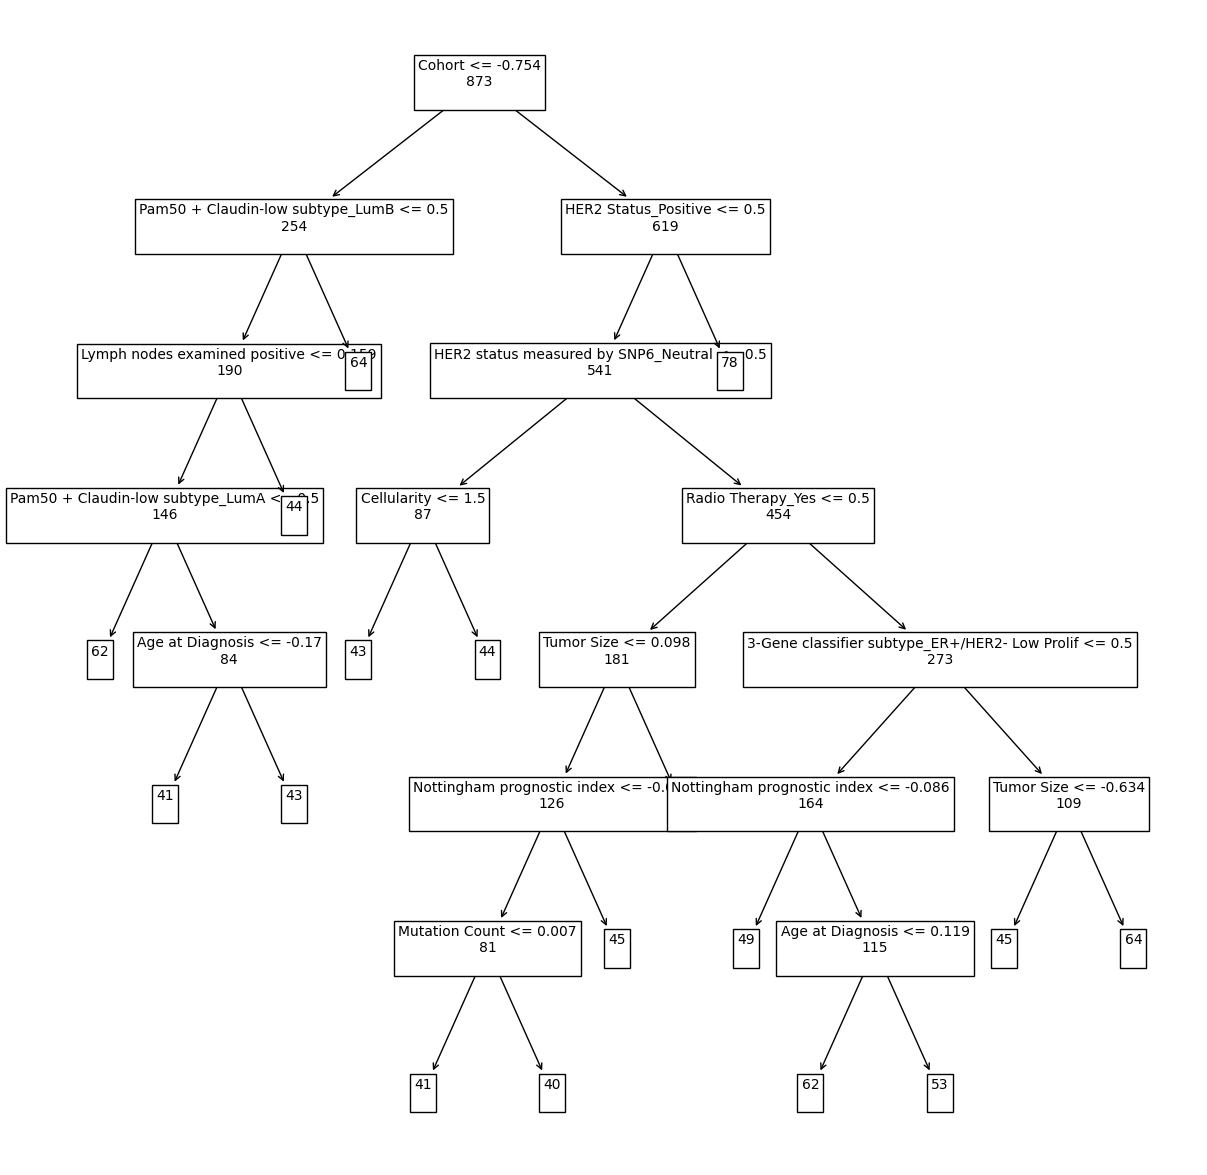

In [ ]:
_, ax = plt.subplots(figsize=(15, 15))

plot_tree(st,
          feature_names = feat_names,
          impurity = False,
          label = None,
          ax = ax,
          fontsize = 10)

[Text(554.3402777777778, 1072.5, 'Cohort <= -0.754\n548\n'),
 Text(193.75, 907.5, 'Pam50 + Claudin-low subtype_LumB <= 0.5\n165\n'),
 Text(150.69444444444446, 742.5, 'Age at Diagnosis <= -1.296\n126\n'),
 Text(107.63888888888889, 577.5, '17\n'),
 Text(193.75, 577.5, 'Hormone Therapy_Yes <= 0.5\n109\n'),
 Text(86.11111111111111, 412.5, 'Primary Tumor Laterality_Right <= 0.5\n21\n'),
 Text(43.05555555555556, 247.5, '11\n'),
 Text(129.16666666666669, 247.5, '10\n'),
 Text(301.3888888888889, 412.5, 'Lymph nodes examined positive <= 0.159\n88\n'),
 Text(215.27777777777777, 247.5, 'Tumor Size <= -0.768\n66\n'),
 Text(172.22222222222223, 82.5, '11\n'),
 Text(258.33333333333337, 82.5, '55\n'),
 Text(387.5, 247.5, 'Cellularity <= 1.5\n22\n'),
 Text(344.44444444444446, 82.5, '11\n'),
 Text(430.55555555555554, 82.5, '11\n'),
 Text(236.80555555555557, 742.5, '39\n'),
 Text(914.9305555555555, 907.5, 'Lymph nodes examined positive <= 0.159\n383\n'),
 Text(753.4722222222223, 742.5, 'Primary Tumor Lat

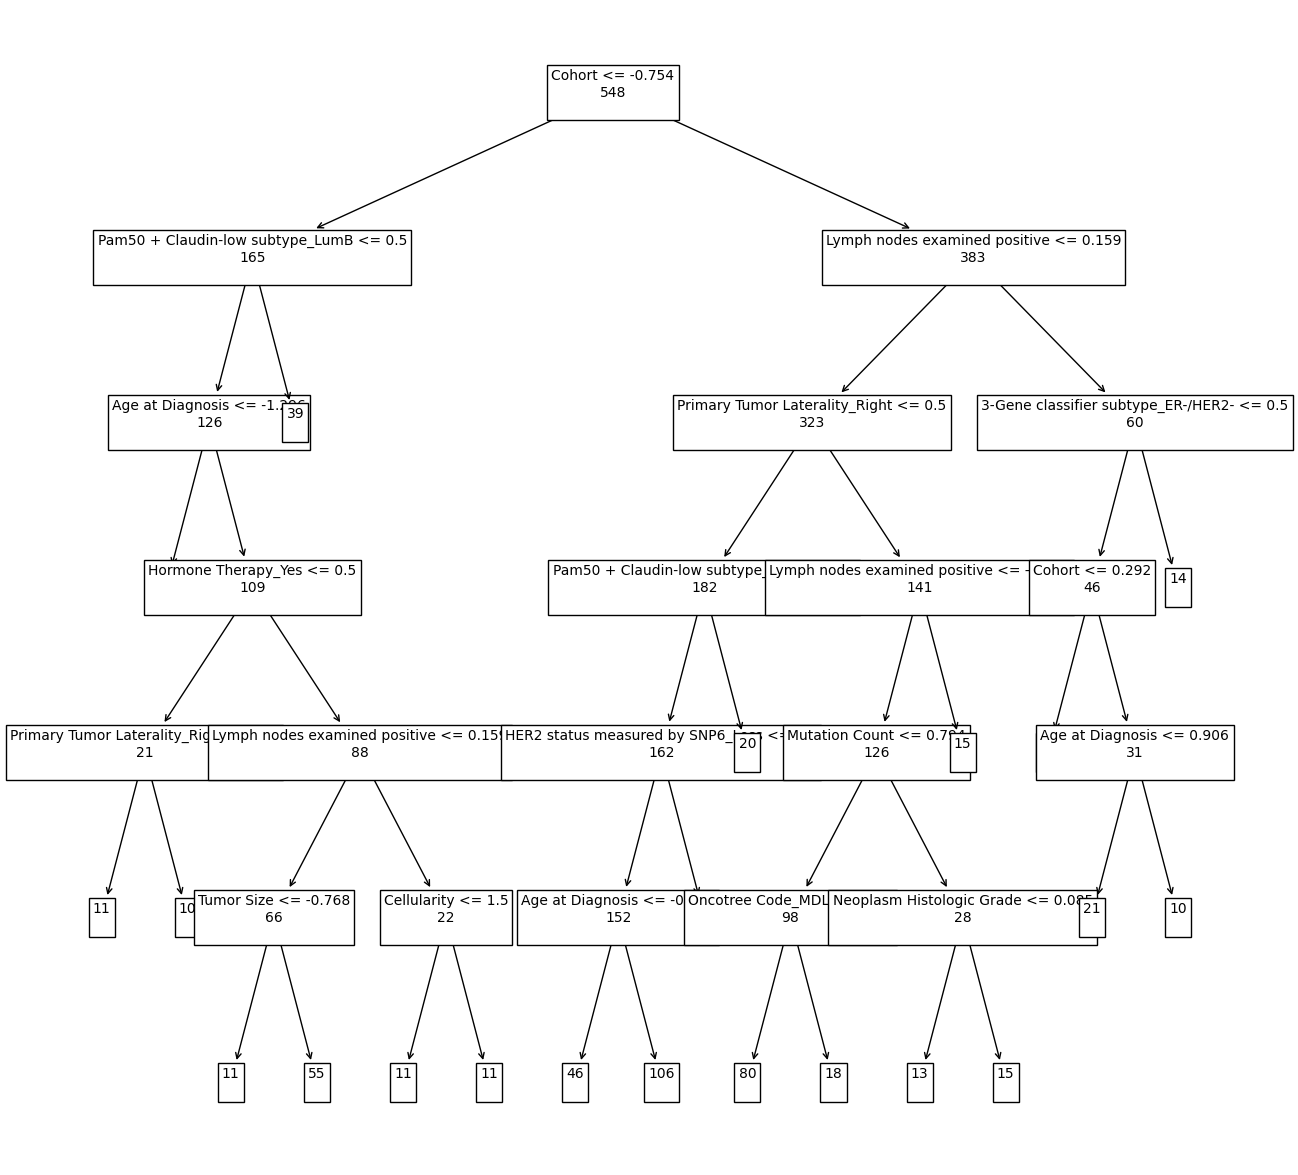

In [ ]:
_, ax = plt.subplots(figsize=(15, 15))

plot_tree(rsf.estimators_[0],
          feature_names = feat_names,
          impurity = False,
          label = None,
          ax = ax,
          fontsize = 10)